In [1]:
# install: tqdm (progress bars)
!pip install tqdm

import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Load the data (CIFAR-10)

new CustomTensorDataset for transforms

In [2]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [3]:
def load_cifar(datadir='./data_cache'): # will download ~400MB of data into this dir. Change the dir if neccesary. If using paperspace, you can make this /storage
    train_ds = ds.CIFAR10(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.CIFAR10(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=4, pin_memory=True)

X_tr, Y_tr, X_te, Y_te = load_cifar()

transform_noaug = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor()])

train_dl = make_loader(CustomTensorDataset([X_tr, Y_tr],transform=transform_noaug))
test_dl = make_loader(CustomTensorDataset([X_te, Y_te],transform=transform_noaug))

Files already downloaded and verified
Files already downloaded and verified


## Training helper functions

In [4]:
def train_epoch(model, train_dl : DataLoader, opt, k = 50):
    ''' Trains model for one epoch on the provided dataloader, with optimizer opt. Logs stats every k batches.'''
    loss_func = nn.CrossEntropyLoss()
    model.train()
    model.cuda()

    netLoss = 0.0
    nCorrect = 0
    nTotal = 0
    for i, (xB, yB) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        xB, yB = xB.cuda(), yB.cuda()
        outputs = model(xB)
        loss = loss_func(outputs, yB)
        loss.backward()
        opt.step()
        netLoss += loss.item() * len(xB)
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
        
        if (i+1) % k == 0:
            train_acc = nCorrect/nTotal
            avg_loss = netLoss/nTotal
            print(f'\t [Batch {i+1} / {len(train_dl)}] Train Loss: {avg_loss:.3f} \t Train Acc: {train_acc:.3f}')
  
    train_acc = nCorrect/nTotal
    avg_loss = netLoss/nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc'''
    model.eval()
    model.cuda()
    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc

In [5]:
## Define model

In [6]:
## 5-Layer CNN for CIFAR
## This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def make_cnn(c=64, num_classes=10):
    ''' Returns a 5-layer CNN with width parameter c. '''
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [7]:
## Train
def train(model, train_dl, test_dl, epochs):
    opt = torch.optim.SGD(model.parameters(), lr=0.1)
    for i in range(epochs):
        print(f'Starting Epoch {i}')
        train_loss, train_acc = train_epoch(model, train_dl, opt)
        test_loss, test_acc = evaluate(model, test_dl)

        print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')
    return train_loss, train_acc, test_loss, test_acc

In [8]:
model = make_cnn()
epochs = 20
train_loss, train_acc, test_loss, test_acc = train(model=model, train_dl=train_dl, test_dl=test_dl, opt=opt, epochs=epochs)

Starting Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 7.842 	 Train Acc: 0.141
	 [Batch 100 / 391] Train Loss: 5.199 	 Train Acc: 0.168
	 [Batch 150 / 391] Train Loss: 4.169 	 Train Acc: 0.194
	 [Batch 200 / 391] Train Loss: 3.606 	 Train Acc: 0.222
	 [Batch 250 / 391] Train Loss: 3.256 	 Train Acc: 0.243
	 [Batch 300 / 391] Train Loss: 3.014 	 Train Acc: 0.259
	 [Batch 350 / 391] Train Loss: 2.822 	 Train Acc: 0.278
Epoch 0:	 Train Loss: 2.697 	 Train Acc: 0.291	 Test Acc: 0.317
Starting Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.573 	 Train Acc: 0.423
	 [Batch 100 / 391] Train Loss: 1.550 	 Train Acc: 0.434
	 [Batch 150 / 391] Train Loss: 1.517 	 Train Acc: 0.444
	 [Batch 200 / 391] Train Loss: 1.503 	 Train Acc: 0.451
	 [Batch 250 / 391] Train Loss: 1.476 	 Train Acc: 0.461
	 [Batch 300 / 391] Train Loss: 1.450 	 Train Acc: 0.472
	 [Batch 350 / 391] Train Loss: 1.431 	 Train Acc: 0.479
Epoch 1:	 Train Loss: 1.419 	 Train Acc: 0.484	 Test Acc: 0.370
Starting Epoch 2


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.239 	 Train Acc: 0.558
	 [Batch 100 / 391] Train Loss: 1.224 	 Train Acc: 0.560
	 [Batch 150 / 391] Train Loss: 1.221 	 Train Acc: 0.560
	 [Batch 200 / 391] Train Loss: 1.213 	 Train Acc: 0.565
	 [Batch 250 / 391] Train Loss: 1.192 	 Train Acc: 0.572
	 [Batch 300 / 391] Train Loss: 1.179 	 Train Acc: 0.577
	 [Batch 350 / 391] Train Loss: 1.167 	 Train Acc: 0.582
Epoch 2:	 Train Loss: 1.156 	 Train Acc: 0.587	 Test Acc: 0.423
Starting Epoch 3


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.037 	 Train Acc: 0.632
	 [Batch 100 / 391] Train Loss: 1.044 	 Train Acc: 0.631
	 [Batch 150 / 391] Train Loss: 1.021 	 Train Acc: 0.640
	 [Batch 200 / 391] Train Loss: 1.008 	 Train Acc: 0.644
	 [Batch 250 / 391] Train Loss: 0.987 	 Train Acc: 0.652
	 [Batch 300 / 391] Train Loss: 0.977 	 Train Acc: 0.656
	 [Batch 350 / 391] Train Loss: 0.971 	 Train Acc: 0.659
Epoch 3:	 Train Loss: 0.965 	 Train Acc: 0.661	 Test Acc: 0.642
Starting Epoch 4


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.865 	 Train Acc: 0.699
	 [Batch 100 / 391] Train Loss: 0.849 	 Train Acc: 0.708
	 [Batch 150 / 391] Train Loss: 0.833 	 Train Acc: 0.714
	 [Batch 200 / 391] Train Loss: 0.838 	 Train Acc: 0.710
	 [Batch 250 / 391] Train Loss: 0.829 	 Train Acc: 0.713
	 [Batch 300 / 391] Train Loss: 0.820 	 Train Acc: 0.716
	 [Batch 350 / 391] Train Loss: 0.813 	 Train Acc: 0.718
Epoch 4:	 Train Loss: 0.809 	 Train Acc: 0.720	 Test Acc: 0.609
Starting Epoch 5


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.745 	 Train Acc: 0.745
	 [Batch 100 / 391] Train Loss: 0.731 	 Train Acc: 0.750
	 [Batch 150 / 391] Train Loss: 0.730 	 Train Acc: 0.749
	 [Batch 200 / 391] Train Loss: 0.721 	 Train Acc: 0.752
	 [Batch 250 / 391] Train Loss: 0.716 	 Train Acc: 0.752
	 [Batch 300 / 391] Train Loss: 0.712 	 Train Acc: 0.753
	 [Batch 350 / 391] Train Loss: 0.704 	 Train Acc: 0.756
Epoch 5:	 Train Loss: 0.704 	 Train Acc: 0.756	 Test Acc: 0.571
Starting Epoch 6


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.603 	 Train Acc: 0.798
	 [Batch 100 / 391] Train Loss: 0.623 	 Train Acc: 0.787
	 [Batch 150 / 391] Train Loss: 0.621 	 Train Acc: 0.789
	 [Batch 200 / 391] Train Loss: 0.611 	 Train Acc: 0.791
	 [Batch 250 / 391] Train Loss: 0.618 	 Train Acc: 0.790
	 [Batch 300 / 391] Train Loss: 0.617 	 Train Acc: 0.790
	 [Batch 350 / 391] Train Loss: 0.613 	 Train Acc: 0.791
Epoch 6:	 Train Loss: 0.611 	 Train Acc: 0.791	 Test Acc: 0.741
Starting Epoch 7


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.533 	 Train Acc: 0.818
	 [Batch 100 / 391] Train Loss: 0.537 	 Train Acc: 0.818
	 [Batch 150 / 391] Train Loss: 0.545 	 Train Acc: 0.815
	 [Batch 200 / 391] Train Loss: 0.542 	 Train Acc: 0.816
	 [Batch 250 / 391] Train Loss: 0.540 	 Train Acc: 0.817
	 [Batch 300 / 391] Train Loss: 0.537 	 Train Acc: 0.817
	 [Batch 350 / 391] Train Loss: 0.541 	 Train Acc: 0.816
Epoch 7:	 Train Loss: 0.541 	 Train Acc: 0.816	 Test Acc: 0.777
Starting Epoch 8


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.463 	 Train Acc: 0.849
	 [Batch 100 / 391] Train Loss: 0.444 	 Train Acc: 0.852
	 [Batch 150 / 391] Train Loss: 0.465 	 Train Acc: 0.846
	 [Batch 200 / 391] Train Loss: 0.461 	 Train Acc: 0.846
	 [Batch 250 / 391] Train Loss: 0.472 	 Train Acc: 0.843
	 [Batch 300 / 391] Train Loss: 0.474 	 Train Acc: 0.842
	 [Batch 350 / 391] Train Loss: 0.465 	 Train Acc: 0.844
Epoch 8:	 Train Loss: 0.465 	 Train Acc: 0.844	 Test Acc: 0.799
Starting Epoch 9


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.386 	 Train Acc: 0.873
	 [Batch 100 / 391] Train Loss: 0.383 	 Train Acc: 0.873
	 [Batch 150 / 391] Train Loss: 0.385 	 Train Acc: 0.872
	 [Batch 200 / 391] Train Loss: 0.405 	 Train Acc: 0.865
	 [Batch 250 / 391] Train Loss: 0.401 	 Train Acc: 0.865
	 [Batch 300 / 391] Train Loss: 0.402 	 Train Acc: 0.865
	 [Batch 350 / 391] Train Loss: 0.403 	 Train Acc: 0.864
Epoch 9:	 Train Loss: 0.405 	 Train Acc: 0.863	 Test Acc: 0.817
Starting Epoch 10


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.330 	 Train Acc: 0.893
	 [Batch 100 / 391] Train Loss: 0.346 	 Train Acc: 0.892
	 [Batch 150 / 391] Train Loss: 0.335 	 Train Acc: 0.894
	 [Batch 200 / 391] Train Loss: 0.331 	 Train Acc: 0.894
	 [Batch 250 / 391] Train Loss: 0.334 	 Train Acc: 0.892
	 [Batch 300 / 391] Train Loss: 0.336 	 Train Acc: 0.891
	 [Batch 350 / 391] Train Loss: 0.339 	 Train Acc: 0.890
Epoch 10:	 Train Loss: 0.340 	 Train Acc: 0.889	 Test Acc: 0.734
Starting Epoch 11


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.287 	 Train Acc: 0.907
	 [Batch 100 / 391] Train Loss: 0.285 	 Train Acc: 0.910
	 [Batch 150 / 391] Train Loss: 0.286 	 Train Acc: 0.908
	 [Batch 200 / 391] Train Loss: 0.288 	 Train Acc: 0.906
	 [Batch 250 / 391] Train Loss: 0.277 	 Train Acc: 0.908
	 [Batch 300 / 391] Train Loss: 0.275 	 Train Acc: 0.908
	 [Batch 350 / 391] Train Loss: 0.280 	 Train Acc: 0.907
Epoch 11:	 Train Loss: 0.287 	 Train Acc: 0.904	 Test Acc: 0.816
Starting Epoch 12


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.137 	 Train Acc: 0.955
	 [Batch 100 / 391] Train Loss: 0.149 	 Train Acc: 0.951
	 [Batch 150 / 391] Train Loss: 0.216 	 Train Acc: 0.938
	 [Batch 200 / 391] Train Loss: 0.216 	 Train Acc: 0.938
	 [Batch 250 / 391] Train Loss: 0.220 	 Train Acc: 0.934
	 [Batch 300 / 391] Train Loss: 0.230 	 Train Acc: 0.930
	 [Batch 350 / 391] Train Loss: 0.227 	 Train Acc: 0.930
Epoch 12:	 Train Loss: 0.234 	 Train Acc: 0.927	 Test Acc: 0.791
Starting Epoch 13


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.110 	 Train Acc: 0.965
	 [Batch 100 / 391] Train Loss: 0.119 	 Train Acc: 0.963
	 [Batch 150 / 391] Train Loss: 0.127 	 Train Acc: 0.960
	 [Batch 200 / 391] Train Loss: 0.141 	 Train Acc: 0.956
	 [Batch 250 / 391] Train Loss: 0.140 	 Train Acc: 0.956
	 [Batch 300 / 391] Train Loss: 0.138 	 Train Acc: 0.956
	 [Batch 350 / 391] Train Loss: 0.151 	 Train Acc: 0.952
Epoch 13:	 Train Loss: 0.164 	 Train Acc: 0.949	 Test Acc: 0.624
Starting Epoch 14


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.132 	 Train Acc: 0.959
	 [Batch 100 / 391] Train Loss: 0.103 	 Train Acc: 0.970
	 [Batch 150 / 391] Train Loss: 0.089 	 Train Acc: 0.974
	 [Batch 200 / 391] Train Loss: 0.083 	 Train Acc: 0.975
	 [Batch 250 / 391] Train Loss: 0.091 	 Train Acc: 0.973
	 [Batch 300 / 391] Train Loss: 0.087 	 Train Acc: 0.974
	 [Batch 350 / 391] Train Loss: 0.100 	 Train Acc: 0.970
Epoch 14:	 Train Loss: 0.100 	 Train Acc: 0.970	 Test Acc: 0.829
Starting Epoch 15


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.035 	 Train Acc: 0.992
	 [Batch 100 / 391] Train Loss: 0.031 	 Train Acc: 0.994
	 [Batch 150 / 391] Train Loss: 0.030 	 Train Acc: 0.994
	 [Batch 200 / 391] Train Loss: 0.029 	 Train Acc: 0.995
	 [Batch 250 / 391] Train Loss: 0.028 	 Train Acc: 0.995
	 [Batch 300 / 391] Train Loss: 0.028 	 Train Acc: 0.995
	 [Batch 350 / 391] Train Loss: 0.027 	 Train Acc: 0.995
Epoch 15:	 Train Loss: 0.027 	 Train Acc: 0.995	 Test Acc: 0.847
Starting Epoch 16


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.011 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 150 / 391] Train Loss: 0.011 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 250 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 300 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 350 / 391] Train Loss: 0.011 	 Train Acc: 0.999
Epoch 16:	 Train Loss: 0.011 	 Train Acc: 0.999	 Test Acc: 0.827
Starting Epoch 17


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.006 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.006 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.006 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.005 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.005 	 Train Acc: 1.000	 Test Acc: 0.856
Starting Epoch 18


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.004 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.004 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.004 	 Train Acc: 1.000	 Test Acc: 0.858
Starting Epoch 19


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.003 	 Train Acc: 1.000	 Test Acc: 0.855


## Problem 1

note: I modified the code above to define a CustomTensorDataset class that allows the application of transforms

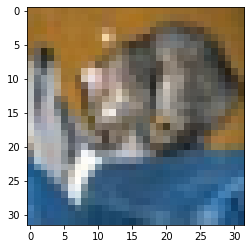

In [9]:
X_te_flip = torch.flip(X_te,[2])
plt.imshow(X_te[0].permute(1, 2, 0))

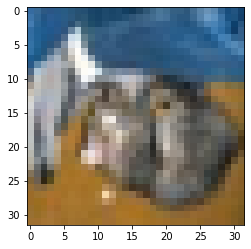

In [10]:
plt.imshow(X_te_flip[0].permute(1, 2, 0)) # confirm flipping has been done correctly


In [11]:
test_dl_flip = make_loader(CustomTensorDataset([X_te_flip, Y_te]))
test_loss_flip, test_acc_flip = evaluate(model, test_dl_flip)
print(f"Overall test accuracy ({100*test_acc}%) and test loss ({test_loss}) for original images")
print(f"Overall test accuracy ({100*test_acc_flip}%) and test loss ({test_loss_flip}) for flipped images")


Overall test accuracy (85.48%) and test loss (0.5576294921875) for original images
Overall test accuracy (42.24%) and test loss (3.0236646484375) for flipped images


In [12]:
cifar10_classnames = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for label in range(10):
    inds = np.where(Y_te==label)
    test_dl_by_label = make_loader(CustomTensorDataset([X_te[inds], Y_te[inds]]))
    test_loss_label, test_acc_label = evaluate(model, test_dl_by_label)
    test_dl_by_label_flip = make_loader(TensorDataset(X_te_flip[inds], Y_te[inds]))
    test_loss_flip_label, test_acc_flip_label = evaluate(model, test_dl_by_label_flip)
    print(f"{cifar10_classnames[label]}: orig. acc {100*test_acc_label}%; acc drop for flipping {100*(test_acc_label-test_acc_flip_label)}%")
    
    

airplane: orig. acc 88.8%; acc drop for flipping 10.899999999999999%
automobile: orig. acc 92.5%; acc drop for flipping 57.900000000000006%
bird: orig. acc 79.4%; acc drop for flipping 44.7%
cat: orig. acc 71.39999999999999%; acc drop for flipping 33.699999999999996%
deer: orig. acc 82.89999999999999%; acc drop for flipping 40.0%
dog: orig. acc 79.80000000000001%; acc drop for flipping 29.300000000000004%
frog: orig. acc 88.0%; acc drop for flipping 20.599999999999994%
horse: orig. acc 87.0%; acc drop for flipping 79.9%
ship: orig. acc 92.9%; acc drop for flipping 66.10000000000001%
truck: orig. acc 92.10000000000001%; acc drop for flipping 49.300000000000004%


In [13]:
transform_aug = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.RandomVerticalFlip(),
     transforms.RandomHorizontalFlip(), # might as well include a random horizontal flip for additional robustness :P
     transforms.ToTensor()])


In [14]:
train_dl_aug = make_loader(CustomTensorDataset([X_tr, Y_tr],transform = transform_aug))
test_dl_aug = make_loader(CustomTensorDataset([X_te, Y_te],transform = transform_aug))

model_aug = make_cnn()
epochs = 40
train_loss_aug, train_acc_aug, test_loss_aug, test_acc_aug = train(model=model_aug, train_dl=train_dl_aug, test_dl=test_dl_aug, epochs=epochs)

Starting Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 5.865 	 Train Acc: 0.159
	 [Batch 100 / 391] Train Loss: 4.040 	 Train Acc: 0.181
	 [Batch 150 / 391] Train Loss: 3.381 	 Train Acc: 0.201
	 [Batch 200 / 391] Train Loss: 3.038 	 Train Acc: 0.215
	 [Batch 250 / 391] Train Loss: 2.810 	 Train Acc: 0.231
	 [Batch 300 / 391] Train Loss: 2.642 	 Train Acc: 0.248
	 [Batch 350 / 391] Train Loss: 2.520 	 Train Acc: 0.261
Epoch 0:	 Train Loss: 2.436 	 Train Acc: 0.272	 Test Acc: 0.360
Starting Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.679 	 Train Acc: 0.379
	 [Batch 100 / 391] Train Loss: 1.659 	 Train Acc: 0.387
	 [Batch 150 / 391] Train Loss: 1.646 	 Train Acc: 0.392
	 [Batch 200 / 391] Train Loss: 1.630 	 Train Acc: 0.401
	 [Batch 250 / 391] Train Loss: 1.613 	 Train Acc: 0.411
	 [Batch 300 / 391] Train Loss: 1.592 	 Train Acc: 0.418
	 [Batch 350 / 391] Train Loss: 1.570 	 Train Acc: 0.427
Epoch 1:	 Train Loss: 1.556 	 Train Acc: 0.432	 Test Acc: 0.376
Starting Epoch 2


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.402 	 Train Acc: 0.491
	 [Batch 100 / 391] Train Loss: 1.400 	 Train Acc: 0.498
	 [Batch 150 / 391] Train Loss: 1.379 	 Train Acc: 0.506
	 [Batch 200 / 391] Train Loss: 1.366 	 Train Acc: 0.511
	 [Batch 250 / 391] Train Loss: 1.351 	 Train Acc: 0.516
	 [Batch 300 / 391] Train Loss: 1.337 	 Train Acc: 0.520
	 [Batch 350 / 391] Train Loss: 1.327 	 Train Acc: 0.522
Epoch 2:	 Train Loss: 1.322 	 Train Acc: 0.525	 Test Acc: 0.368
Starting Epoch 3


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.221 	 Train Acc: 0.568
	 [Batch 100 / 391] Train Loss: 1.204 	 Train Acc: 0.571
	 [Batch 150 / 391] Train Loss: 1.209 	 Train Acc: 0.571
	 [Batch 200 / 391] Train Loss: 1.187 	 Train Acc: 0.579
	 [Batch 250 / 391] Train Loss: 1.181 	 Train Acc: 0.583
	 [Batch 300 / 391] Train Loss: 1.173 	 Train Acc: 0.585
	 [Batch 350 / 391] Train Loss: 1.167 	 Train Acc: 0.588
Epoch 3:	 Train Loss: 1.165 	 Train Acc: 0.587	 Test Acc: 0.552
Starting Epoch 4


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.111 	 Train Acc: 0.609
	 [Batch 100 / 391] Train Loss: 1.088 	 Train Acc: 0.614
	 [Batch 150 / 391] Train Loss: 1.084 	 Train Acc: 0.614
	 [Batch 200 / 391] Train Loss: 1.076 	 Train Acc: 0.616
	 [Batch 250 / 391] Train Loss: 1.067 	 Train Acc: 0.621
	 [Batch 300 / 391] Train Loss: 1.055 	 Train Acc: 0.625
	 [Batch 350 / 391] Train Loss: 1.048 	 Train Acc: 0.628
Epoch 4:	 Train Loss: 1.044 	 Train Acc: 0.629	 Test Acc: 0.600
Starting Epoch 5


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.002 	 Train Acc: 0.653
	 [Batch 100 / 391] Train Loss: 0.991 	 Train Acc: 0.654
	 [Batch 150 / 391] Train Loss: 0.981 	 Train Acc: 0.655
	 [Batch 200 / 391] Train Loss: 0.978 	 Train Acc: 0.656
	 [Batch 250 / 391] Train Loss: 0.973 	 Train Acc: 0.658
	 [Batch 300 / 391] Train Loss: 0.972 	 Train Acc: 0.659
	 [Batch 350 / 391] Train Loss: 0.963 	 Train Acc: 0.662
Epoch 5:	 Train Loss: 0.961 	 Train Acc: 0.662	 Test Acc: 0.552
Starting Epoch 6


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.912 	 Train Acc: 0.676
	 [Batch 100 / 391] Train Loss: 0.906 	 Train Acc: 0.678
	 [Batch 150 / 391] Train Loss: 0.907 	 Train Acc: 0.680
	 [Batch 200 / 391] Train Loss: 0.904 	 Train Acc: 0.680
	 [Batch 250 / 391] Train Loss: 0.900 	 Train Acc: 0.682
	 [Batch 300 / 391] Train Loss: 0.896 	 Train Acc: 0.684
	 [Batch 350 / 391] Train Loss: 0.893 	 Train Acc: 0.684
Epoch 6:	 Train Loss: 0.892 	 Train Acc: 0.685	 Test Acc: 0.613
Starting Epoch 7


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.839 	 Train Acc: 0.702
	 [Batch 100 / 391] Train Loss: 0.844 	 Train Acc: 0.707
	 [Batch 150 / 391] Train Loss: 0.835 	 Train Acc: 0.708
	 [Batch 200 / 391] Train Loss: 0.835 	 Train Acc: 0.708
	 [Batch 250 / 391] Train Loss: 0.837 	 Train Acc: 0.706
	 [Batch 300 / 391] Train Loss: 0.840 	 Train Acc: 0.706
	 [Batch 350 / 391] Train Loss: 0.836 	 Train Acc: 0.707
Epoch 7:	 Train Loss: 0.833 	 Train Acc: 0.709	 Test Acc: 0.668
Starting Epoch 8


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.815 	 Train Acc: 0.714
	 [Batch 100 / 391] Train Loss: 0.810 	 Train Acc: 0.716
	 [Batch 150 / 391] Train Loss: 0.792 	 Train Acc: 0.723
	 [Batch 200 / 391] Train Loss: 0.787 	 Train Acc: 0.726
	 [Batch 250 / 391] Train Loss: 0.784 	 Train Acc: 0.727
	 [Batch 300 / 391] Train Loss: 0.784 	 Train Acc: 0.727
	 [Batch 350 / 391] Train Loss: 0.779 	 Train Acc: 0.728
Epoch 8:	 Train Loss: 0.779 	 Train Acc: 0.728	 Test Acc: 0.567
Starting Epoch 9


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.744 	 Train Acc: 0.739
	 [Batch 100 / 391] Train Loss: 0.740 	 Train Acc: 0.737
	 [Batch 150 / 391] Train Loss: 0.741 	 Train Acc: 0.737
	 [Batch 200 / 391] Train Loss: 0.738 	 Train Acc: 0.739
	 [Batch 250 / 391] Train Loss: 0.736 	 Train Acc: 0.742
	 [Batch 300 / 391] Train Loss: 0.734 	 Train Acc: 0.743
	 [Batch 350 / 391] Train Loss: 0.732 	 Train Acc: 0.744
Epoch 9:	 Train Loss: 0.734 	 Train Acc: 0.743	 Test Acc: 0.709
Starting Epoch 10


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.701 	 Train Acc: 0.755
	 [Batch 100 / 391] Train Loss: 0.697 	 Train Acc: 0.759
	 [Batch 150 / 391] Train Loss: 0.696 	 Train Acc: 0.761
	 [Batch 200 / 391] Train Loss: 0.693 	 Train Acc: 0.760
	 [Batch 250 / 391] Train Loss: 0.697 	 Train Acc: 0.758
	 [Batch 300 / 391] Train Loss: 0.693 	 Train Acc: 0.759
	 [Batch 350 / 391] Train Loss: 0.692 	 Train Acc: 0.759
Epoch 10:	 Train Loss: 0.692 	 Train Acc: 0.759	 Test Acc: 0.704
Starting Epoch 11


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.661 	 Train Acc: 0.767
	 [Batch 100 / 391] Train Loss: 0.655 	 Train Acc: 0.770
	 [Batch 150 / 391] Train Loss: 0.669 	 Train Acc: 0.768
	 [Batch 200 / 391] Train Loss: 0.660 	 Train Acc: 0.770
	 [Batch 250 / 391] Train Loss: 0.657 	 Train Acc: 0.771
	 [Batch 300 / 391] Train Loss: 0.656 	 Train Acc: 0.772
	 [Batch 350 / 391] Train Loss: 0.654 	 Train Acc: 0.773
Epoch 11:	 Train Loss: 0.653 	 Train Acc: 0.773	 Test Acc: 0.422
Starting Epoch 12


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.614 	 Train Acc: 0.783
	 [Batch 100 / 391] Train Loss: 0.612 	 Train Acc: 0.786
	 [Batch 150 / 391] Train Loss: 0.621 	 Train Acc: 0.784
	 [Batch 200 / 391] Train Loss: 0.622 	 Train Acc: 0.784
	 [Batch 250 / 391] Train Loss: 0.619 	 Train Acc: 0.786
	 [Batch 300 / 391] Train Loss: 0.616 	 Train Acc: 0.787
	 [Batch 350 / 391] Train Loss: 0.613 	 Train Acc: 0.788
Epoch 12:	 Train Loss: 0.613 	 Train Acc: 0.788	 Test Acc: 0.717
Starting Epoch 13


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.618 	 Train Acc: 0.790
	 [Batch 100 / 391] Train Loss: 0.600 	 Train Acc: 0.795
	 [Batch 150 / 391] Train Loss: 0.598 	 Train Acc: 0.793
	 [Batch 200 / 391] Train Loss: 0.595 	 Train Acc: 0.794
	 [Batch 250 / 391] Train Loss: 0.592 	 Train Acc: 0.795
	 [Batch 300 / 391] Train Loss: 0.590 	 Train Acc: 0.796
	 [Batch 350 / 391] Train Loss: 0.593 	 Train Acc: 0.795
Epoch 13:	 Train Loss: 0.589 	 Train Acc: 0.796	 Test Acc: 0.731
Starting Epoch 14


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.566 	 Train Acc: 0.802
	 [Batch 100 / 391] Train Loss: 0.554 	 Train Acc: 0.808
	 [Batch 150 / 391] Train Loss: 0.556 	 Train Acc: 0.808
	 [Batch 200 / 391] Train Loss: 0.561 	 Train Acc: 0.807
	 [Batch 250 / 391] Train Loss: 0.558 	 Train Acc: 0.808
	 [Batch 300 / 391] Train Loss: 0.558 	 Train Acc: 0.807
	 [Batch 350 / 391] Train Loss: 0.558 	 Train Acc: 0.807
Epoch 14:	 Train Loss: 0.560 	 Train Acc: 0.807	 Test Acc: 0.746
Starting Epoch 15


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.535 	 Train Acc: 0.816
	 [Batch 100 / 391] Train Loss: 0.528 	 Train Acc: 0.820
	 [Batch 150 / 391] Train Loss: 0.530 	 Train Acc: 0.818
	 [Batch 200 / 391] Train Loss: 0.525 	 Train Acc: 0.819
	 [Batch 250 / 391] Train Loss: 0.521 	 Train Acc: 0.819
	 [Batch 300 / 391] Train Loss: 0.526 	 Train Acc: 0.818
	 [Batch 350 / 391] Train Loss: 0.523 	 Train Acc: 0.818
Epoch 15:	 Train Loss: 0.524 	 Train Acc: 0.818	 Test Acc: 0.751
Starting Epoch 16


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.517 	 Train Acc: 0.826
	 [Batch 100 / 391] Train Loss: 0.502 	 Train Acc: 0.829
	 [Batch 150 / 391] Train Loss: 0.506 	 Train Acc: 0.826
	 [Batch 200 / 391] Train Loss: 0.499 	 Train Acc: 0.827
	 [Batch 250 / 391] Train Loss: 0.499 	 Train Acc: 0.828
	 [Batch 300 / 391] Train Loss: 0.501 	 Train Acc: 0.827
	 [Batch 350 / 391] Train Loss: 0.501 	 Train Acc: 0.827
Epoch 16:	 Train Loss: 0.502 	 Train Acc: 0.826	 Test Acc: 0.680
Starting Epoch 17


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.464 	 Train Acc: 0.837
	 [Batch 100 / 391] Train Loss: 0.468 	 Train Acc: 0.837
	 [Batch 150 / 391] Train Loss: 0.481 	 Train Acc: 0.832
	 [Batch 200 / 391] Train Loss: 0.478 	 Train Acc: 0.833
	 [Batch 250 / 391] Train Loss: 0.481 	 Train Acc: 0.832
	 [Batch 300 / 391] Train Loss: 0.480 	 Train Acc: 0.832
	 [Batch 350 / 391] Train Loss: 0.478 	 Train Acc: 0.833
Epoch 17:	 Train Loss: 0.482 	 Train Acc: 0.832	 Test Acc: 0.704
Starting Epoch 18


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.466 	 Train Acc: 0.839
	 [Batch 100 / 391] Train Loss: 0.454 	 Train Acc: 0.844
	 [Batch 150 / 391] Train Loss: 0.453 	 Train Acc: 0.843
	 [Batch 200 / 391] Train Loss: 0.457 	 Train Acc: 0.841
	 [Batch 250 / 391] Train Loss: 0.451 	 Train Acc: 0.843
	 [Batch 300 / 391] Train Loss: 0.454 	 Train Acc: 0.843
	 [Batch 350 / 391] Train Loss: 0.455 	 Train Acc: 0.842
Epoch 18:	 Train Loss: 0.453 	 Train Acc: 0.843	 Test Acc: 0.756
Starting Epoch 19


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.442 	 Train Acc: 0.848
	 [Batch 100 / 391] Train Loss: 0.435 	 Train Acc: 0.850
	 [Batch 150 / 391] Train Loss: 0.426 	 Train Acc: 0.853
	 [Batch 200 / 391] Train Loss: 0.427 	 Train Acc: 0.853
	 [Batch 250 / 391] Train Loss: 0.432 	 Train Acc: 0.852
	 [Batch 300 / 391] Train Loss: 0.435 	 Train Acc: 0.850
	 [Batch 350 / 391] Train Loss: 0.435 	 Train Acc: 0.850
Epoch 19:	 Train Loss: 0.431 	 Train Acc: 0.851	 Test Acc: 0.775
Starting Epoch 20


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.403 	 Train Acc: 0.858
	 [Batch 100 / 391] Train Loss: 0.415 	 Train Acc: 0.856
	 [Batch 150 / 391] Train Loss: 0.416 	 Train Acc: 0.856
	 [Batch 200 / 391] Train Loss: 0.409 	 Train Acc: 0.858
	 [Batch 250 / 391] Train Loss: 0.418 	 Train Acc: 0.855
	 [Batch 300 / 391] Train Loss: 0.408 	 Train Acc: 0.859
	 [Batch 350 / 391] Train Loss: 0.410 	 Train Acc: 0.858
Epoch 20:	 Train Loss: 0.410 	 Train Acc: 0.858	 Test Acc: 0.769
Starting Epoch 21


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.373 	 Train Acc: 0.874
	 [Batch 100 / 391] Train Loss: 0.370 	 Train Acc: 0.872
	 [Batch 150 / 391] Train Loss: 0.377 	 Train Acc: 0.871
	 [Batch 200 / 391] Train Loss: 0.381 	 Train Acc: 0.870
	 [Batch 250 / 391] Train Loss: 0.388 	 Train Acc: 0.867
	 [Batch 300 / 391] Train Loss: 0.389 	 Train Acc: 0.866
	 [Batch 350 / 391] Train Loss: 0.393 	 Train Acc: 0.865
Epoch 21:	 Train Loss: 0.396 	 Train Acc: 0.864	 Test Acc: 0.763
Starting Epoch 22


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.393 	 Train Acc: 0.864
	 [Batch 100 / 391] Train Loss: 0.381 	 Train Acc: 0.868
	 [Batch 150 / 391] Train Loss: 0.373 	 Train Acc: 0.871
	 [Batch 200 / 391] Train Loss: 0.372 	 Train Acc: 0.872
	 [Batch 250 / 391] Train Loss: 0.369 	 Train Acc: 0.874
	 [Batch 300 / 391] Train Loss: 0.368 	 Train Acc: 0.874
	 [Batch 350 / 391] Train Loss: 0.370 	 Train Acc: 0.873
Epoch 22:	 Train Loss: 0.374 	 Train Acc: 0.873	 Test Acc: 0.779
Starting Epoch 23


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.345 	 Train Acc: 0.881
	 [Batch 100 / 391] Train Loss: 0.335 	 Train Acc: 0.884
	 [Batch 150 / 391] Train Loss: 0.342 	 Train Acc: 0.882
	 [Batch 200 / 391] Train Loss: 0.345 	 Train Acc: 0.880
	 [Batch 250 / 391] Train Loss: 0.349 	 Train Acc: 0.879
	 [Batch 300 / 391] Train Loss: 0.351 	 Train Acc: 0.877
	 [Batch 350 / 391] Train Loss: 0.351 	 Train Acc: 0.877
Epoch 23:	 Train Loss: 0.351 	 Train Acc: 0.878	 Test Acc: 0.703
Starting Epoch 24


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.355 	 Train Acc: 0.880
	 [Batch 100 / 391] Train Loss: 0.354 	 Train Acc: 0.878
	 [Batch 150 / 391] Train Loss: 0.343 	 Train Acc: 0.881
	 [Batch 200 / 391] Train Loss: 0.343 	 Train Acc: 0.880
	 [Batch 250 / 391] Train Loss: 0.342 	 Train Acc: 0.880
	 [Batch 300 / 391] Train Loss: 0.343 	 Train Acc: 0.880
	 [Batch 350 / 391] Train Loss: 0.347 	 Train Acc: 0.879
Epoch 24:	 Train Loss: 0.345 	 Train Acc: 0.879	 Test Acc: 0.774
Starting Epoch 25


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.287 	 Train Acc: 0.900
	 [Batch 100 / 391] Train Loss: 0.301 	 Train Acc: 0.897
	 [Batch 150 / 391] Train Loss: 0.307 	 Train Acc: 0.894
	 [Batch 200 / 391] Train Loss: 0.318 	 Train Acc: 0.890
	 [Batch 250 / 391] Train Loss: 0.317 	 Train Acc: 0.890
	 [Batch 300 / 391] Train Loss: 0.317 	 Train Acc: 0.890
	 [Batch 350 / 391] Train Loss: 0.318 	 Train Acc: 0.891
Epoch 25:	 Train Loss: 0.320 	 Train Acc: 0.890	 Test Acc: 0.811
Starting Epoch 26


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.303 	 Train Acc: 0.899
	 [Batch 100 / 391] Train Loss: 0.287 	 Train Acc: 0.902
	 [Batch 150 / 391] Train Loss: 0.297 	 Train Acc: 0.899
	 [Batch 200 / 391] Train Loss: 0.299 	 Train Acc: 0.897
	 [Batch 250 / 391] Train Loss: 0.299 	 Train Acc: 0.897
	 [Batch 300 / 391] Train Loss: 0.303 	 Train Acc: 0.896
	 [Batch 350 / 391] Train Loss: 0.304 	 Train Acc: 0.895
Epoch 26:	 Train Loss: 0.302 	 Train Acc: 0.895	 Test Acc: 0.790
Starting Epoch 27


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.262 	 Train Acc: 0.913
	 [Batch 100 / 391] Train Loss: 0.273 	 Train Acc: 0.909
	 [Batch 150 / 391] Train Loss: 0.274 	 Train Acc: 0.908
	 [Batch 200 / 391] Train Loss: 0.270 	 Train Acc: 0.908
	 [Batch 250 / 391] Train Loss: 0.274 	 Train Acc: 0.907
	 [Batch 300 / 391] Train Loss: 0.278 	 Train Acc: 0.906
	 [Batch 350 / 391] Train Loss: 0.284 	 Train Acc: 0.904
Epoch 27:	 Train Loss: 0.285 	 Train Acc: 0.903	 Test Acc: 0.765
Starting Epoch 28


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.299 	 Train Acc: 0.903
	 [Batch 100 / 391] Train Loss: 0.273 	 Train Acc: 0.910
	 [Batch 150 / 391] Train Loss: 0.275 	 Train Acc: 0.908
	 [Batch 200 / 391] Train Loss: 0.276 	 Train Acc: 0.906
	 [Batch 250 / 391] Train Loss: 0.274 	 Train Acc: 0.907
	 [Batch 300 / 391] Train Loss: 0.274 	 Train Acc: 0.907
	 [Batch 350 / 391] Train Loss: 0.273 	 Train Acc: 0.907
Epoch 28:	 Train Loss: 0.271 	 Train Acc: 0.907	 Test Acc: 0.813
Starting Epoch 29


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.262 	 Train Acc: 0.912
	 [Batch 100 / 391] Train Loss: 0.269 	 Train Acc: 0.909
	 [Batch 150 / 391] Train Loss: 0.266 	 Train Acc: 0.910
	 [Batch 200 / 391] Train Loss: 0.257 	 Train Acc: 0.912
	 [Batch 250 / 391] Train Loss: 0.257 	 Train Acc: 0.912
	 [Batch 300 / 391] Train Loss: 0.263 	 Train Acc: 0.911
	 [Batch 350 / 391] Train Loss: 0.261 	 Train Acc: 0.912
Epoch 29:	 Train Loss: 0.260 	 Train Acc: 0.912	 Test Acc: 0.798
Starting Epoch 30


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.217 	 Train Acc: 0.927
	 [Batch 100 / 391] Train Loss: 0.231 	 Train Acc: 0.922
	 [Batch 150 / 391] Train Loss: 0.233 	 Train Acc: 0.921
	 [Batch 200 / 391] Train Loss: 0.231 	 Train Acc: 0.922
	 [Batch 250 / 391] Train Loss: 0.231 	 Train Acc: 0.922
	 [Batch 300 / 391] Train Loss: 0.232 	 Train Acc: 0.921
	 [Batch 350 / 391] Train Loss: 0.231 	 Train Acc: 0.920
Epoch 30:	 Train Loss: 0.239 	 Train Acc: 0.918	 Test Acc: 0.820
Starting Epoch 31


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.227 	 Train Acc: 0.928
	 [Batch 100 / 391] Train Loss: 0.225 	 Train Acc: 0.927
	 [Batch 150 / 391] Train Loss: 0.220 	 Train Acc: 0.927
	 [Batch 200 / 391] Train Loss: 0.224 	 Train Acc: 0.925
	 [Batch 250 / 391] Train Loss: 0.221 	 Train Acc: 0.925
	 [Batch 300 / 391] Train Loss: 0.225 	 Train Acc: 0.925
	 [Batch 350 / 391] Train Loss: 0.225 	 Train Acc: 0.924
Epoch 31:	 Train Loss: 0.227 	 Train Acc: 0.923	 Test Acc: 0.772
Starting Epoch 32


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.192 	 Train Acc: 0.936
	 [Batch 100 / 391] Train Loss: 0.182 	 Train Acc: 0.938
	 [Batch 150 / 391] Train Loss: 0.190 	 Train Acc: 0.937
	 [Batch 200 / 391] Train Loss: 0.192 	 Train Acc: 0.936
	 [Batch 250 / 391] Train Loss: 0.193 	 Train Acc: 0.935
	 [Batch 300 / 391] Train Loss: 0.197 	 Train Acc: 0.933
	 [Batch 350 / 391] Train Loss: 0.200 	 Train Acc: 0.932
Epoch 32:	 Train Loss: 0.201 	 Train Acc: 0.932	 Test Acc: 0.777
Starting Epoch 33


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.182 	 Train Acc: 0.941
	 [Batch 100 / 391] Train Loss: 0.177 	 Train Acc: 0.941
	 [Batch 150 / 391] Train Loss: 0.178 	 Train Acc: 0.940
	 [Batch 200 / 391] Train Loss: 0.178 	 Train Acc: 0.940
	 [Batch 250 / 391] Train Loss: 0.189 	 Train Acc: 0.936
	 [Batch 300 / 391] Train Loss: 0.190 	 Train Acc: 0.936
	 [Batch 350 / 391] Train Loss: 0.192 	 Train Acc: 0.935
Epoch 33:	 Train Loss: 0.191 	 Train Acc: 0.935	 Test Acc: 0.818
Starting Epoch 34


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.169 	 Train Acc: 0.942
	 [Batch 100 / 391] Train Loss: 0.164 	 Train Acc: 0.943
	 [Batch 150 / 391] Train Loss: 0.175 	 Train Acc: 0.940
	 [Batch 200 / 391] Train Loss: 0.180 	 Train Acc: 0.939
	 [Batch 250 / 391] Train Loss: 0.188 	 Train Acc: 0.937
	 [Batch 300 / 391] Train Loss: 0.187 	 Train Acc: 0.937
	 [Batch 350 / 391] Train Loss: 0.185 	 Train Acc: 0.938
Epoch 34:	 Train Loss: 0.187 	 Train Acc: 0.937	 Test Acc: 0.832
Starting Epoch 35


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.138 	 Train Acc: 0.955
	 [Batch 100 / 391] Train Loss: 0.145 	 Train Acc: 0.951
	 [Batch 150 / 391] Train Loss: 0.144 	 Train Acc: 0.951
	 [Batch 200 / 391] Train Loss: 0.151 	 Train Acc: 0.947
	 [Batch 250 / 391] Train Loss: 0.152 	 Train Acc: 0.948
	 [Batch 300 / 391] Train Loss: 0.154 	 Train Acc: 0.947
	 [Batch 350 / 391] Train Loss: 0.160 	 Train Acc: 0.946
Epoch 35:	 Train Loss: 0.165 	 Train Acc: 0.944	 Test Acc: 0.789
Starting Epoch 36


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.144 	 Train Acc: 0.949
	 [Batch 100 / 391] Train Loss: 0.144 	 Train Acc: 0.951
	 [Batch 150 / 391] Train Loss: 0.138 	 Train Acc: 0.954
	 [Batch 200 / 391] Train Loss: 0.142 	 Train Acc: 0.952
	 [Batch 250 / 391] Train Loss: 0.143 	 Train Acc: 0.951
	 [Batch 300 / 391] Train Loss: 0.147 	 Train Acc: 0.950
	 [Batch 350 / 391] Train Loss: 0.150 	 Train Acc: 0.949
Epoch 36:	 Train Loss: 0.154 	 Train Acc: 0.948	 Test Acc: 0.811
Starting Epoch 37


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.136 	 Train Acc: 0.958
	 [Batch 100 / 391] Train Loss: 0.130 	 Train Acc: 0.958
	 [Batch 150 / 391] Train Loss: 0.131 	 Train Acc: 0.957
	 [Batch 200 / 391] Train Loss: 0.136 	 Train Acc: 0.955
	 [Batch 250 / 391] Train Loss: 0.138 	 Train Acc: 0.955
	 [Batch 300 / 391] Train Loss: 0.138 	 Train Acc: 0.954
	 [Batch 350 / 391] Train Loss: 0.145 	 Train Acc: 0.952
Epoch 37:	 Train Loss: 0.146 	 Train Acc: 0.952	 Test Acc: 0.814
Starting Epoch 38


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.113 	 Train Acc: 0.963
	 [Batch 100 / 391] Train Loss: 0.122 	 Train Acc: 0.959
	 [Batch 150 / 391] Train Loss: 0.122 	 Train Acc: 0.959
	 [Batch 200 / 391] Train Loss: 0.130 	 Train Acc: 0.956
	 [Batch 250 / 391] Train Loss: 0.130 	 Train Acc: 0.956
	 [Batch 300 / 391] Train Loss: 0.129 	 Train Acc: 0.957
	 [Batch 350 / 391] Train Loss: 0.134 	 Train Acc: 0.955
Epoch 38:	 Train Loss: 0.133 	 Train Acc: 0.955	 Test Acc: 0.801
Starting Epoch 39


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.097 	 Train Acc: 0.968
	 [Batch 100 / 391] Train Loss: 0.111 	 Train Acc: 0.963
	 [Batch 150 / 391] Train Loss: 0.110 	 Train Acc: 0.963
	 [Batch 200 / 391] Train Loss: 0.113 	 Train Acc: 0.963
	 [Batch 250 / 391] Train Loss: 0.119 	 Train Acc: 0.961
	 [Batch 300 / 391] Train Loss: 0.116 	 Train Acc: 0.962
	 [Batch 350 / 391] Train Loss: 0.117 	 Train Acc: 0.962
Epoch 39:	 Train Loss: 0.118 	 Train Acc: 0.961	 Test Acc: 0.823


I added horizontal and vertical flipping for data augmentation - horizontal flipping as prescribed by the problem, and vertical flipping as it generally seems like a good idea for the kind of data we are working with in CIFAR10. After all, a vertically flipped dog still looks very much like a dog. As the training accuracy was still improving after 20 epochs, I increased the number of total epochs to 40. Accuracies as requested are below.

In [16]:
test_loss_orig, test_acc_orig = evaluate(model_aug, test_dl)
test_loss_flip, test_acc_flip = evaluate(model_aug, test_dl_flip)
print(f"Accuracy on original test data: {100*test_acc_orig}%")
print(f"Accuracy on vertically flipped test data: {100*test_acc_flip}%")

Accuracy on original test data: 82.17999999999999%
Accuracy on vertically flipped test data: 82.26%
